In [9]:
%pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns

import sys
sys.path.append('parser')

from parser import AvxTurbo

In [2]:
files = glob.glob('results/*.datafile')
files

['results/2025-02-06.datafile',
 'results/2025-02-10.datafile',
 'results/2025-02-11.datafile']

In [3]:
result = AvxTurbo.parse(files[2])
result.experiments

[Experiment(cores=1, name='pause_only', description='pause instruction', ovrlp3=1.0, mops=[9746], aperf_mperf_ratio=[1.9], aperf_mperf_mhz=[3800], mperf_tsc_ratio=[1.0]),
 Experiment(cores=1, name='ucomis_clean', description='scalar ucomis (w/ vzeroupper)', ovrlp3=1.0, mops=[1900], aperf_mperf_ratio=[1.9], aperf_mperf_mhz=[3800], mperf_tsc_ratio=[1.0]),
 Experiment(cores=1, name='ucomis_dirty', description='scalar ucomis (no vzeroupper)', ovrlp3=1.0, mops=[1900], aperf_mperf_ratio=[1.9], aperf_mperf_mhz=[3800], mperf_tsc_ratio=[1.0]),
 Experiment(cores=1, name='scalar_iadd', description='Scalar integer adds', ovrlp3=1.0, mops=[3801], aperf_mperf_ratio=[1.9], aperf_mperf_mhz=[3800], mperf_tsc_ratio=[1.0]),
 Experiment(cores=1, name='avx128_iadd', description='128-bit integer serial adds', ovrlp3=1.0, mops=[3801], aperf_mperf_ratio=[1.9], aperf_mperf_mhz=[3800], mperf_tsc_ratio=[1.0]),
 Experiment(cores=1, name='avx256_iadd', description='256-bit integer serial adds', ovrlp3=1.0, mops=[3

In [4]:
def average(input):
    return sum(input) / len(input)

function = max

freq_vs_number_of_cores = pd.DataFrame()
first_socket = pd.DataFrame()
second_socket = pd.DataFrame()

for experiment in result.experiments:
    freq_vs_number_of_cores = pd.concat([freq_vs_number_of_cores, pd.DataFrame([{'cores': experiment.cores, 'frequencies': function(experiment.aperf_mperf_mhz), 'type': experiment.name}])])

freq_vs_number_of_cores
        

,cores,frequencies,type
0,1,3800,pause_only
0,1,3800,ucomis_clean
0,1,3800,ucomis_dirty
0,1,3800,scalar_iadd
0,1,3800,avx128_iadd
...,...,...,...
0,112,2500,avx512_fma_t
0,112,3000,avx512_vpermw
0,112,3000,avx512_vpermw_t
0,112,3000,avx512_vpermd


In [5]:
def square(value):
    return value ** 2

import math

def ln_square(value):
    return math.log(value) ** 2

types = sorted(set(freq_vs_number_of_cores['type']))

lms = pd.DataFrame()

for type1 in types:
    view1 = freq_vs_number_of_cores[freq_vs_number_of_cores['type'] == type1]
    print(view1)
    for type2 in types:
        view2 = freq_vs_number_of_cores[freq_vs_number_of_cores['type'] == type2]
        value = sum(map(ln_square, view1['frequencies'] / view2['frequencies']))
        lms = pd.concat([lms, pd.DataFrame([{'type1': type1, 'type2': type2, 'lms': value}])])

lms

    cores  frequencies        type
0       1         3800  avx128_fma
0       2         3800  avx128_fma
0       3         3800  avx128_fma
0       4         3800  avx128_fma
0       5         3800  avx128_fma
..    ...          ...         ...
0     108         3000  avx128_fma
0     109         3000  avx128_fma
0     110         3000  avx128_fma
0     111         3000  avx128_fma
0     112         3000  avx128_fma

[112 rows x 3 columns]
    cores  frequencies               type
0       1         3800  avx128_fma_sparse
0       2         3800  avx128_fma_sparse
0       3         3800  avx128_fma_sparse
0       4         3800  avx128_fma_sparse
0       5         3800  avx128_fma_sparse
..    ...          ...                ...
0     108         3000  avx128_fma_sparse
0     109         3000  avx128_fma_sparse
0     110         3000  avx128_fma_sparse
0     111         3000  avx128_fma_sparse
0     112         3001  avx128_fma_sparse

[112 rows x 3 columns]
    cores  frequencies      

,type1,type2,lms
0,avx128_fma,avx128_fma,0.000000
0,avx128_fma,avx128_fma_sparse,0.000055
0,avx128_fma,avx128_fma_t,0.000137
0,avx128_fma,avx128_iadd,0.000052
0,avx128_fma,avx128_iadd16,0.000059
...,...,...,...
0,ucomis_dirty,avx512_xor_zero,0.001007
0,ucomis_dirty,pause_only,0.000013
0,ucomis_dirty,scalar_iadd,0.000004
0,ucomis_dirty,ucomis_clean,0.000137


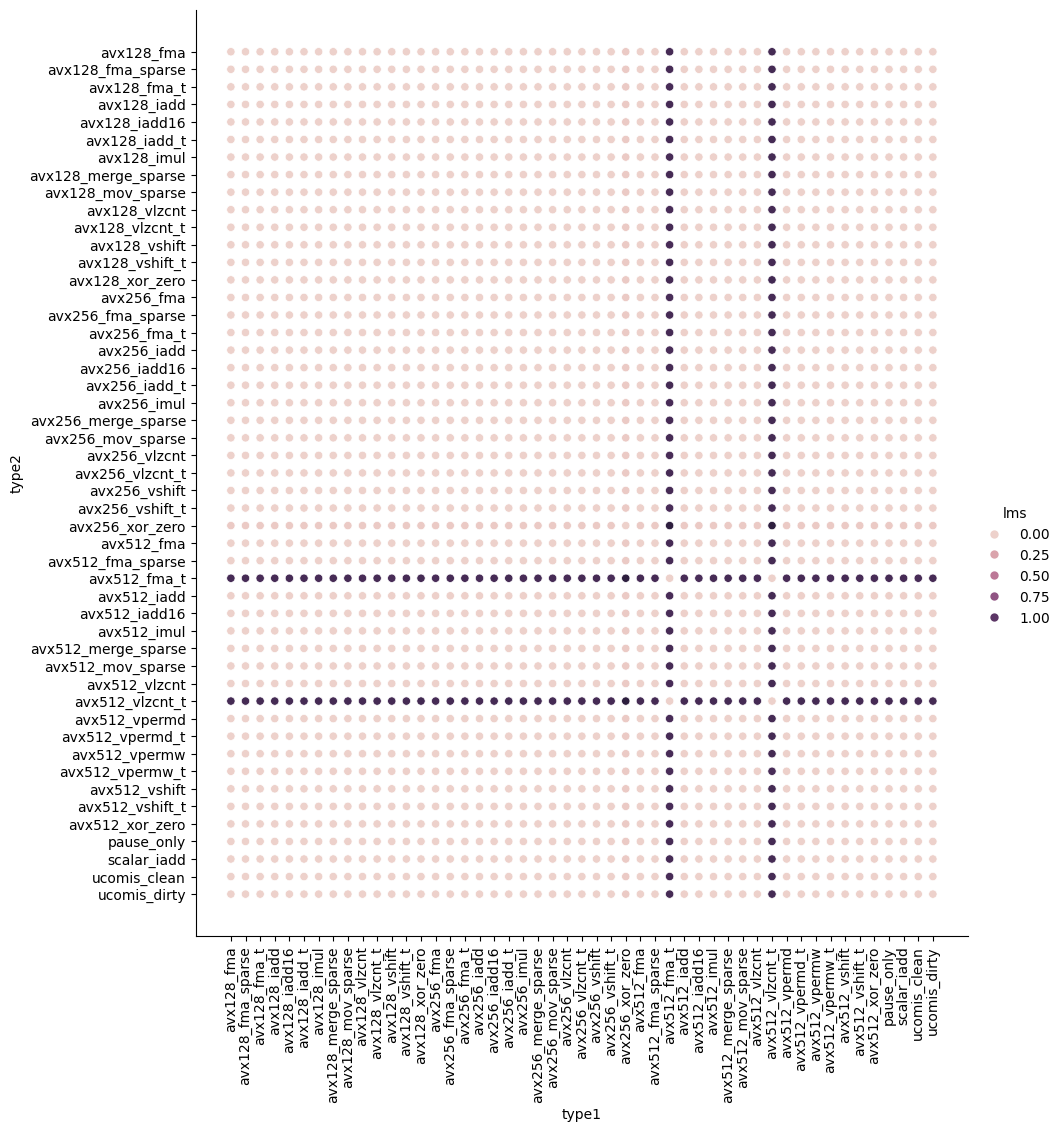

In [6]:
# sns.set_theme(rc={'figure.figsize':(10, 10), 'legend.fontsize': 13, 'font.size': 13})

g = sns.relplot(lms, x='type1', y='type2', hue='lms', height=10, aspect=1)

# plt.legend(ncol=4, bbox_to_anchor=(0.5, -0.1), loc="upper center")
for label in g.ax.get_xticklabels():
    label.set_rotation(90)

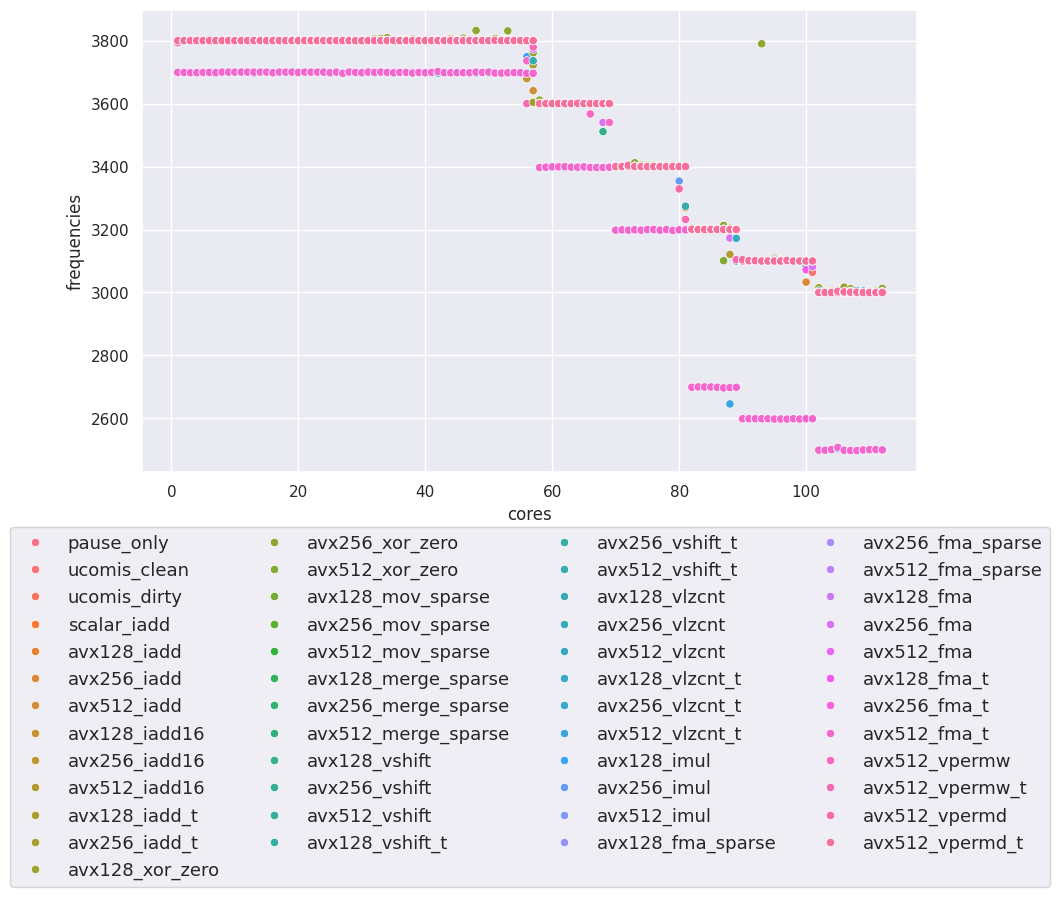

In [7]:
sns.set_theme(rc={'figure.figsize':(10, 6), 'legend.fontsize': 13, 'font.size': 13})
ax = sns.scatterplot(data=freq_vs_number_of_cores, x='cores', y='frequencies', hue='type')
plt.legend(ncol=4, bbox_to_anchor=(0.5, -0.1), loc="upper center")

# ax.set_ylim(0, 4000)

<Axes: xlabel='frequencies', ylabel='type'>

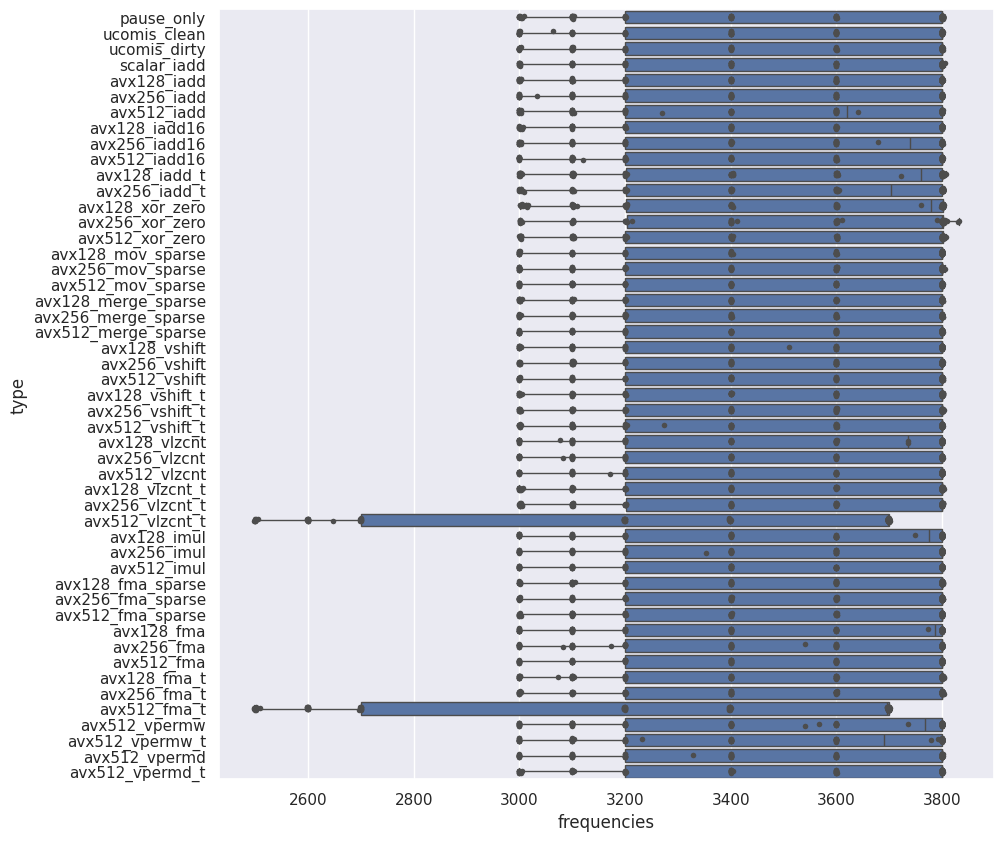

In [8]:
sns.set_theme(rc={'figure.figsize':(10, 10), 'legend.fontsize': 13, 'font.size': 13})

sns.boxplot(
    freq_vs_number_of_cores, y="type", x="frequencies"
)

sns.stripplot(freq_vs_number_of_cores, y="type", x="frequencies", size=4, color=".3")